# Notebook to compute the spike phase coupling
(Davis et al. 2023)
- We calculate degree of spike coupling on each channel to the LFP phase: spike-phase index. This index is calculated by taking the lenth of the circulant resultant of the spike phase distribution.
    - We detect spikes from the LFP. First we filter LFP with a hp filter. Second we detect spikes using an arbitrary threshold (c*std).
    - We compute LFP phase mesuring the generalized phase (GP): The use of a wider filter than traditionally used (4-8, 8-15..) helps reduce phase distortions that occur when applying narrowband filters to signals that have a broad spectral content.
- We calculate the preferred phase angle 
- We calculate the circular cross correlation between LFP phase on each channel and LFP phase on each other channel.

In [1]:
import numpy as np
from numpy.core.umath import pi,mod
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy.signal import butter, sosfiltfilt, filtfilt
import numpy as np
import scipy as sp
from ephysvibe.analysis import raw_ch,circular_stats
import os
import mne


### Def gp functions

In [2]:
def mat_select_seg(lfp,spk,i_seg):
    sp_bool = np.zeros((32,10000))
    for i,i_sp in enumerate(spk):
        mask = np.logical_and(i_sp>=i_seg,i_sp<i_seg+10000)
        sp_bool[i,i_sp[mask]-1-i_seg]=1

    seg_lfp = lfp[:,i_seg:i_seg+10000]
    return seg_lfp, sp_bool

### Load data

In [3]:
continuous_path = '/envau/work/invibe/USERS/IBOS/openephys/Riesling/2023-01-20_11-00-24/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat'
c_samples = np.load('/envau/work/invibe/USERS/IBOS/openephys/Riesling/2023-01-20_11-00-24/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/sample_numbers.npy')
shape_0 = len(c_samples)

In [4]:
n_channels=163                       
sample_rate=30000
print(shape_0,n_channels)
args={'sample_rate':sample_rate,'n_channels_dat':n_channels,'dtype':"int16"}
cont = raw_ch.load_continuous_dat(continuous_path, **args)

125200128 163


In [5]:

# avg_lfp = np.median(cont[:300000+30000,:32],axis=0).reshape(1,-1)
# reference_lfp=(cont[:300000+30000,:32]-avg_lfp)
# avg_lfp = np.median(reference_lfp,axis=1).reshape(-1,1)
# reference_lfp=(reference_lfp-avg_lfp)

# cont_hp = raw_ch.filter_continuous(reference_lfp,fs=30000,fc_hp=500,axis=0) # High pass filter

# step=1
# win = 30000
# d_shape=cont_hp.shape
# idx_ds = np.arange(0,300000+30000-30,  30)
# # Detect spikes using a threshold
# fig,ax=plt.subplots(figsize=(25,5))
# ch = 0

# std = np.std(raw_ch.rolling_window(cont_hp[idx_ds,ch], window=1000, step=1),axis=1)
# #std = np.concatenate([std,np.full(999,std[-1])])

# ax.plot(cont_hp[idx_ds,ch][:len(std)])
# thresh = -3*std
# ax.plot(thresh)
# #ax.plot(diff*400)

In [6]:
from scipy.fft import fft,fftfreq

In [13]:
from scipy.signal import butter, sosfilt

In [51]:
seg_hp = cont[300000 : 300000*2, :n_channels].astype(float).T
avg_lfp_ch = np.median(seg_hp, axis=1).reshape(-1, 1)
seg_hp = seg_hp - avg_lfp_ch
#avg_lfp = np.median(seg_hp, axis=1).reshape(-1, 1)
seg_hp2 = mne.filter.filter_data(seg_hp[0], sfreq=30000, l_freq=3, h_freq=250, method='fir',verbose=False) # High pass filter
hp_sos = butter(4, 250, "lp", fs=30000, output="sos")
lp_sos = butter(4, 3, "hp", fs=30000, output="sos")
seg_hp3 = sosfilt(hp_sos, seg_hp[0])
seg_hp3 = sosfilt(lp_sos, seg_hp3)

(300000,)

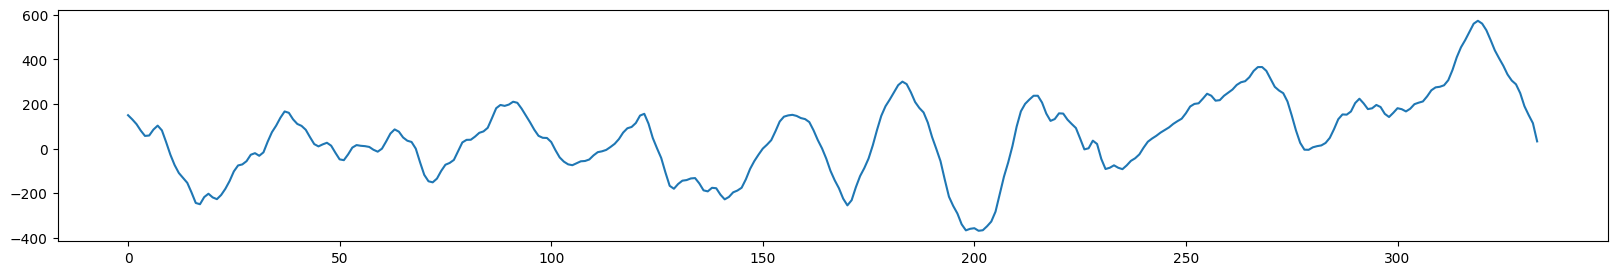

In [44]:
fig,ax = plt.subplots(figsize=(20,3))
plt.plot(seg_hp2[np.arange(290000,300000,30)]) 
seg_hp2.shape

(300000,)

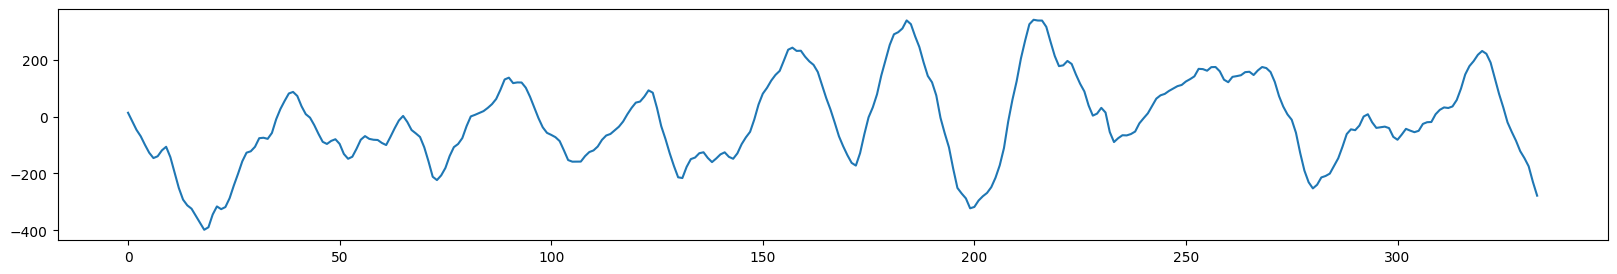

In [45]:
fig,ax = plt.subplots(figsize=(20,3))
plt.plot(seg_hp3[np.arange(290000,300000,30)]) 
seg_hp3.shape

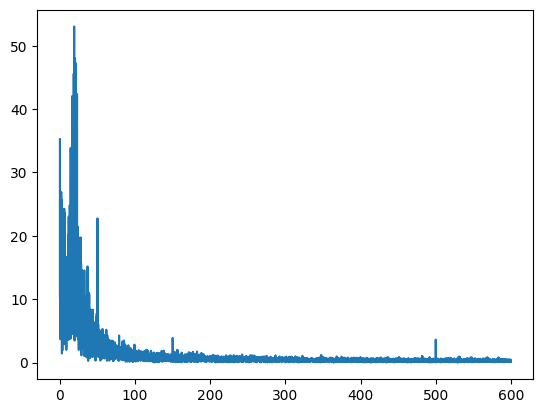

In [43]:
[chs,N]=seg_lp.shape
T = 1/30000
x0=fft(seg_lp,N,axis=1)
xf = fftfreq(N, T)[:N//50]
plt.plot(xf, 2.0/N * np.abs(x0[5,0:N//50]))

In [7]:
fs = 1000
dt = 1/fs
order = 4
lp_f = 40
hp_f = 5
passband = [hp_f, lp_f]#[hp_f/(fs/2), lp_f/(fs/2)]

In [16]:
# Compute GP
session_duration = (cont.shape[0] / 30000) / 60
if session_duration < 60:
    print('error')

minute_min = 20 * 60 * 1000 * 30
minute_max = minute_min + (40 * 60 * 1000 * 30)
raw_step = 300000
raw_1sec = 30000
seg = np.arange(0, int((minute_max - minute_min)), raw_step) + minute_min
seg_phase_spikes = []
idx_ds_sp = np.arange(0, raw_step + raw_1sec, 30)
idx_ds_lfp = np.arange(0, raw_step, 30)
n_channels = 32

for i_seg in seg:
    # spike data = freq > 500 Hz

    seg_hp = cont[i_seg : i_seg + raw_step + raw_1sec, :n_channels].astype(float).T
    avg_lfp_ch = np.median(seg_hp, axis=1).reshape(-1, 1)
    seg_hp = seg_hp - avg_lfp_ch
    #avg_lfp = np.median(seg_hp, axis=1).reshape(-1, 1)
    seg_hp = mne.filter.filter_data(seg_hp, sfreq=30000, l_freq=500, h_freq=None, method='fir',verbose=False) # High pass filter
    ## subsample
    seg_hp = seg_hp[ :,idx_ds_sp]
    ## detect spikes
    seg_sp = raw_ch.detect_spikes(seg_hp,win=1000)
    # LFP
    seg_lp = cont[i_seg : i_seg + raw_step, :n_channels].astype(float).T # Low pass filter
    avg_lfp_ch = np.median(seg_lp, axis=1).reshape(-1, 1)
    seg_lp = seg_lp - avg_lfp_ch
    seg_lp=mne.filter.filter_data(seg_lp, sfreq=30000, l_freq=None, h_freq=300, method='fir',verbose=False)
    seg_lp = seg_lp[ :,idx_ds_lfp]
    b, a  = butter(order, passband, "bandpass", fs=1000)
    x_lfp = filtfilt(
        b, a , seg_lp, padtype="odd", padlen=3*(max(len(b),len(a))-1), axis=1
    )
    # compute gp
    xgp, wt = circular_stats.compute_generalized_phase(x_lfp, dt)
    phase_lfp = np.angle(xgp.astype(complex))

    # Spike phases
    phase_spikes = []  # np.zeros(n_channels,n_channels)
    for lfp_ch in range(0, n_channels):
        ch_phase_spikes = []
        for sp_ch in range(0, n_channels):
            if np.sum(seg_sp[sp_ch]) != 0:  # No spikes? No phase
                ch_phase_spikes.append(
                    phase_lfp[lfp_ch, seg_sp[sp_ch].astype(bool)]
                )
            else:
                ch_phase_spikes.append([np.nan])
        phase_spikes.append(ch_phase_spikes)
    seg_phase_spikes.append(phase_spikes)

In [9]:
# # Compute GP
# session_duration = (cont.shape[0] / 30000) / 60
# if session_duration < 60:
#     print('error')

# minute_min = 20 * 60 * 1000 * 30
# minute_max = minute_min + (20 * 60 * 1000 * 30)
# raw_step = 300000
# raw_1sec = 30000
# seg = np.arange(0, int((minute_max - minute_min)), raw_step) + minute_min
# seg_phase_spikes = []
# idx_ds_sp = np.arange(0, raw_step + raw_1sec, 30)
# idx_ds_lfp = np.arange(0, raw_step, 30)
# n_channels = 32

# for i_seg in seg:
#     # spike data = freq > 500 Hz

#     seg_hp = cont[i_seg : i_seg + raw_step + raw_1sec, :n_channels]
#     # avg_lfp_ch = np.median(seg_hp, axis=0).reshape(1, -1)
#     # seg_hp = seg_hp - avg_lfp_ch
#     avg_lfp = np.median(seg_hp, axis=1).reshape(-1, 1)

#     seg_hp = seg_hp - avg_lfp
#     seg_hp = raw_ch.filter_continuous(
#         seg_hp, fs=30000, fc_hp=500, axis=1 #! axis=1
#     )  # High pass filter
#     ## subsample
#     seg_hp = seg_hp[idx_ds_sp, :32].T 
#     ## detect spikes
#     seg_sp = raw_ch.detect_spikes(seg_hp)

#     # LFP
#     seg_lp = cont[i_seg : i_seg + raw_step, :n_channels]
#     avg_lfp = np.median(seg_lp, axis=1).reshape(-1, 1)
#     seg_lp = seg_lp - avg_lfp
#     # seg_lp = raw_ch.filter_continuous(
#     #     seg_lp, fs=30000, fc_lp=300, axis=0
#     # )  # Low pass filter
#     b, a = butter(order, passband, "bandpass")
#     x_lfp = filtfilt(
#         b, a, seg_lp, padtype="odd", padlen=3 * (max(len(b), len(a)) - 1), axis=1
#     )
#     x_lfp = x_lfp[idx_ds_lfp, :n_channels].T
#     # compute gp
#     xgp, wt = circular_stats.compute_generalized_phase(x_lfp, dt)
#     phase_lfp = np.angle(xgp.astype(complex))

#     # Spike phases
#     phase_spikes = []  # np.zeros(n_channels,n_channels)
#     for lfp_ch in range(0, n_channels):
#         ch_phase_spikes = []
#         for sp_ch in range(0, n_channels):
#             if np.sum(seg_sp[sp_ch]) != 0:  # No spikes? No phase
#                 ch_phase_spikes.append(
#                     phase_lfp[lfp_ch, seg_sp[sp_ch].astype(bool)]
#                 )
#             else:
#                 ch_phase_spikes.append([np.nan])
#         phase_spikes.append(ch_phase_spikes)
#     seg_phase_spikes.append(phase_spikes)

In [17]:
ps = []
for lfp_ch in range(0,n_channels):
    ps_2 = []
    for sp_ch in range(0,n_channels):
        ps_1 = []
        for i_seg in np.arange(0,len(seg_phase_spikes)):
            ps_1.append(seg_phase_spikes[i_seg][lfp_ch][sp_ch])
        ps_2.append(np.concatenate(ps_1))
    ps.append(ps_2)

In [18]:
# spike phase index (SPI): 1 all spikes occur at a single phase, 0 perfectly uniform spike-phase distribution
spike_phase = np.full((n_channels,n_channels),np.nan)
pref_phase = np.full((n_channels,n_channels),np.nan)
phase_corr = np.full((n_channels,n_channels),np.nan)
for lfp_ch in range(0,n_channels):

    for sp_ch in range(0,n_channels):
        #phase_sp = np.concatenate(ps[lfp_ch][sp_ch])
        phase_sp = ps[lfp_ch][sp_ch][~np.isnan(ps[lfp_ch][sp_ch])]
        spike_phase[lfp_ch,sp_ch] = circular_stats.resultant_vector_length(alpha=phase_sp) # mod
        pref_phase[lfp_ch,sp_ch] = circular_stats.mean_direction(alpha=phase_sp) # phase
        phase_corr[lfp_ch,sp_ch] = circular_stats.corrcc(phase_lfp[lfp_ch], phase_lfp[sp_ch])

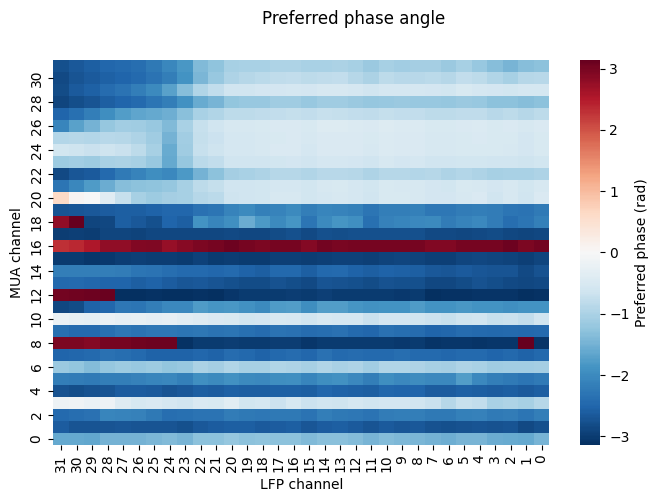

In [19]:
fig,ax = plt.subplots(figsize=(8,5))
cmap=sns.color_palette("RdBu_r", 300)
sns.heatmap(pref_phase.T,cmap=cmap,cbar_kws={'label': 'Preferred phase (rad)'},vmin=-pi,vmax=pi)
ax.invert_yaxis()
ax.invert_xaxis()
fig.suptitle('Preferred phase angle')
ax.set(xlabel="LFP channel", ylabel="MUA channel")
plt.show()

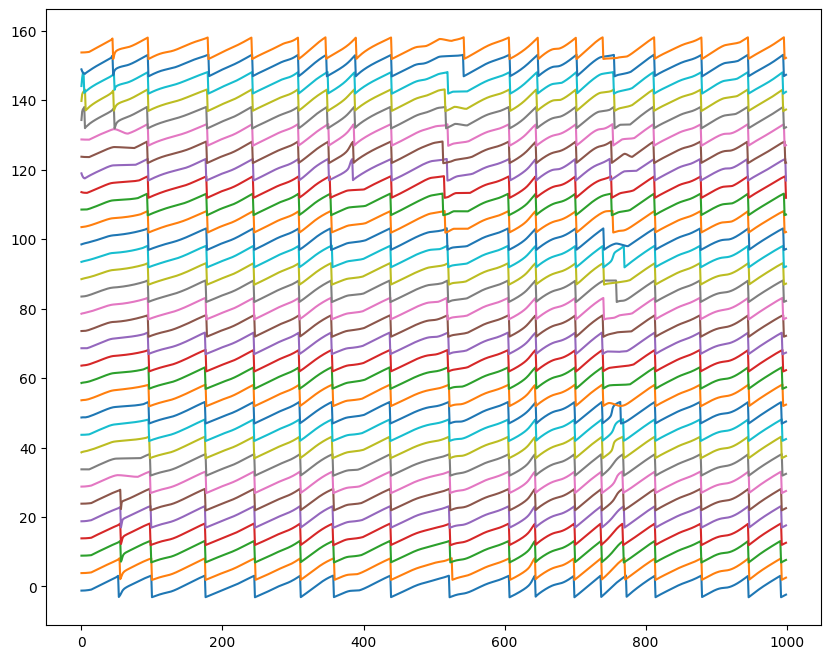

In [20]:
fig,ax = plt.subplots(figsize=(10,8))
a=ax.plot(phase_lfp[:,:1000].T+np.arange(0,32*5,5))

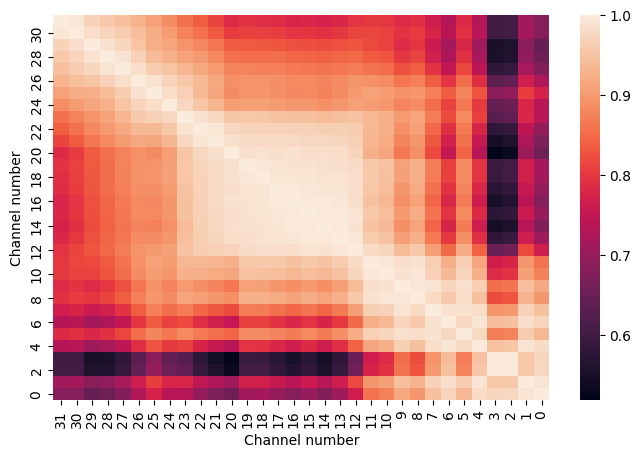

In [21]:
_,ax = plt.subplots(figsize=(8,5))
sns.heatmap(phase_corr)
ax.invert_yaxis()
ax.invert_xaxis()
fig.suptitle('Phase correlation')
ax.set(xlabel="Channel number", ylabel="Channel number")
plt.show()

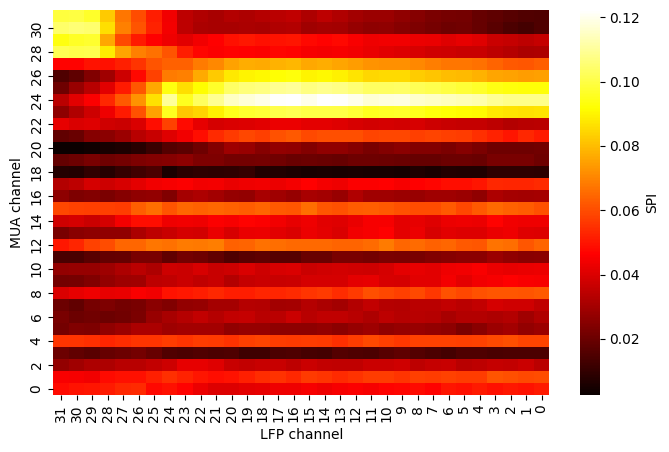

In [22]:
# SPI: 0 -> perfectly uniform spike-phase distribution, 1 -> all spikes occur at a single phase
_,ax = plt.subplots(figsize=(8,5))
sns.heatmap(spike_phase.T,cmap='hot',cbar_kws={'label': 'SPI'})
ax.invert_yaxis()
ax.invert_xaxis()
fig.suptitle('Spike phase index (SPI)')
ax.set(xlabel="LFP channel", ylabel="MUA channel")
plt.show()

## Mat data

In [33]:
# Load Matlab data
f=sp.io.loadmat('/home/INT/losada.c/Downloads/exData3.mat')
spk = np.concatenate(f['spikeTimes'])
lfp = np.concatenate(f['LFP'][0])
permutation =np.flip(f['chanMap'].reshape(-1)-1)
all_lfp=lfp[ permutation,:] # return a rearranged copy
all_sp = spk[ permutation]

In [107]:
fs = 1000
dt = 1/fs
order = 4
lp_f = 40
hp_f = 5
passband = [hp_f/(fs/2), lp_f/(fs/2)]

In [34]:
min_20 = 20*60*1000*30
min_50 = 50*60*1000*30

seg_phase_spikes = []

n_channels=32
n_seg = np.floor(np.max(all_lfp.shape)/(fs*10))*10000
seg = np.arange(0,n_seg,10000)
for i_seg in seg:
    
    seg_lfp,seg_sp = mat_select_seg(all_lfp,all_sp,int(i_seg))
    # Select segment of the data 
       
    # lfp data
    #seg_lp = filter_continuous(cont[i_seg:i_seg+300000,:n_channels],fs=30000,fc_lp=300,axis=0) # Low pass filter


    b, a = butter(4, passband, 'bandpass',fs=fs)
    x_lfp = filtfilt(b, a, seg_lfp,padtype = 'odd', padlen=3*(max(len(b),len(a))-1),axis=1)
    # x_lfp=x_lfp[idx_ds,:n_channels].T
    # compute gp
    xgp, wt = circular_stats.compute_generalized_phase(x_lfp,dt)
    phase_lfp = np.angle(xgp.astype(complex))

    # Spike phases
    phase_spikes = []#np.zeros(n_channels,n_channels)

    for lfp_ch in range(0,n_channels):
        
        ch_phase_spikes = []
        for sp_ch in range(0,n_channels):
            
            if np.sum(seg_sp[sp_ch]) !=0: # No spikes? No phase
                ch_phase_spikes.append(phase_lfp[lfp_ch,seg_sp[sp_ch].astype(bool)])
            else:
                ch_phase_spikes.append([np.nan])
        phase_spikes.append(ch_phase_spikes)
    
    seg_phase_spikes.append(phase_spikes)

In [35]:
ps = []
for lfp_ch in range(0,n_channels):
    ps_2 = []
    for sp_ch in range(0,n_channels):
        ps_1 = []
        for i_seg in np.arange(0,len(seg_phase_spikes)):
            ps_1.append(seg_phase_spikes[i_seg][lfp_ch][sp_ch])
        ps_2.append(np.concatenate(ps_1))
    ps.append(ps_2)

In [36]:
# spike phase index (SPI): 1 all spikes occur at a single phase, 0 perfectly uniform spike-phase distribution
spike_phase = np.full((n_channels,n_channels),np.nan)
pref_phase = np.full((n_channels,n_channels),np.nan)
phase_corr = np.full((n_channels,n_channels),np.nan)
for lfp_ch in range(0,n_channels):

    for sp_ch in range(0,n_channels):
        #phase_sp = np.concatenate(ps[lfp_ch][sp_ch])
        phase_sp = ps[lfp_ch][sp_ch][~np.isnan(ps[lfp_ch][sp_ch])]
        spike_phase[lfp_ch,sp_ch] = circular_stats.resultant_vector_length(alpha=phase_sp) 
        pref_phase[lfp_ch,sp_ch] = circular_stats.mean_direction(alpha=phase_sp)
        phase_corr[lfp_ch,sp_ch] = circular_stats.corrcc(phase_lfp[lfp_ch], phase_lfp[sp_ch])

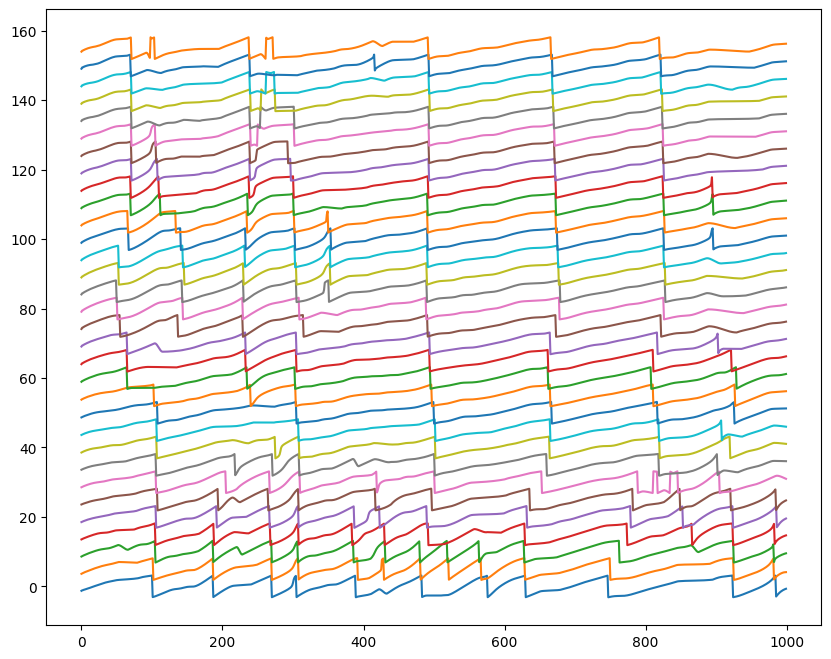

In [40]:
fig,ax = plt.subplots(figsize=(10,8))
a=ax.plot(phase_lfp[:,:1000].T+np.arange(0,32*5,5))

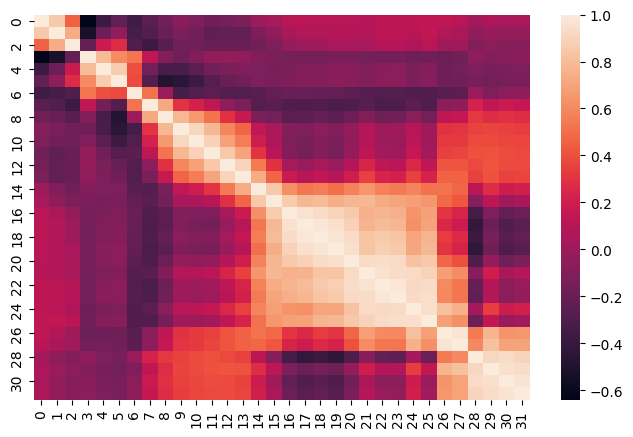

In [37]:
_,ax = plt.subplots(figsize=(8,5))
sns.heatmap(phase_corr)
#ax.invert_yaxis()
plt.show()

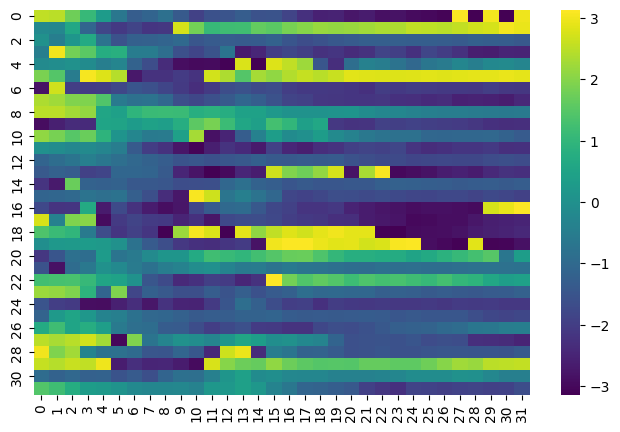

In [38]:
_,ax = plt.subplots(figsize=(8,5))
sns.heatmap(pref_phase.T,cmap='viridis')
plt.show()

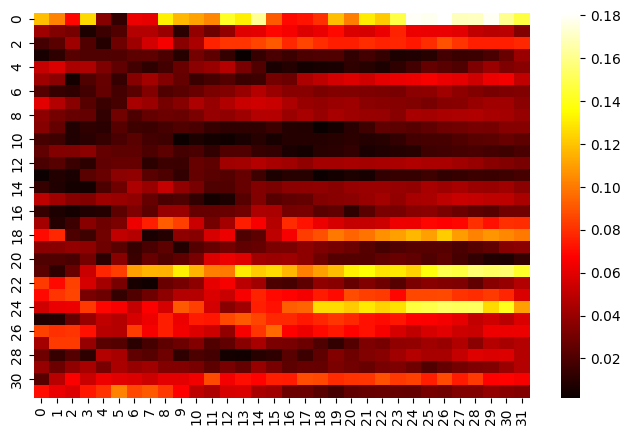

In [39]:
_,ax = plt.subplots(figsize=(8,5))
sns.heatmap(spike_phase.T,cmap='hot')
#ax.invert_yaxis()
plt.show()